# Example 2: Within-subject design

In this example, we will present the case of a pure within-subject design

In [1]:
# system and io packages
# python2.7
import sys
import cPickle as pickle

#Basic packages
import pandas as pd
import numpy as np

#statistics packages
from scipy.stats import ttest_ind
from scipy.stats import ttest_rel
from scipy.stats import spearmanr
import statsmodels.api as sm
from statsmodels.formula.api import ols
%load_ext rpy2.ipython
from rpy2.robjects import r, pandas2ri

#plot packages
import matplotlib
import matplotlib.pyplot as plt
from pylab import *
import seaborn as sns
%matplotlib inline

import plotly.plotly as py
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot,iplot_mpl
from plotly.graph_objs import *
import cufflinks as cf
init_notebook_mode(connected=True)

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets



# other packages
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

/Users/genghaiyang/anaconda2/envs/gluon/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [1]:
# check which python is in use.
import sys
print('Notebook is running:', sys.executable)

# further check your python version
from platform import python_version

print('The current HDDM version is', python_version())

# If you are sure that conda is installed, also check the package that install
#!conda list  # list the conda

import hddm, IPython, kabuki, pymc
import numpy as np
import pandas as pd
import seaborn as sns
print('The current HDDM version is', hddm.__version__) # 0.8.0
print('The current Kabuki version is', kabuki.__version__) # 0.6.3
print('The current PyMC version is', pymc.__version__) # 2.3.8

# Warning:`IPython.parallel` package has been deprecated since IPython 4.0. 
print('The current IPython version is', IPython.__version__) 

print('The current Numpy version is', np.__version__) 

print('The current Pandas version is', pd.__version__)

print('The current seaborn version is', sns.__version__)

Notebook is running: /home/hcp4715/miniconda3/envs/hddm/bin/python
The current HDDM version is 3.7.7
The current HDDM version is 0.8.0
The current Kabuki version is 0.6.3
The current PyMC version is 2.3.8
The current IPython version is 7.13.0
The current Numpy version is 1.18.5
The current Pandas version is 1.0.4
The current seaborn version is 0.11.1


/home/hcp4715/miniconda3/envs/hddm/lib/python3.7/site-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)


In [2]:
%matplotlib inline

# Preparation
import os, time, csv
from datetime import date
import random

import kabuki, hddm
from patsy import dmatrix

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Experimental design

In this case, we actually have 2 * 3 design, the first factor is concening the stimulus type, and linked to different response. In this case, there is a strong interaction between the two factors, and for the condition B, there is no sig differences between the three levels, either in RT or ACC, but in condition A, there is sig diff. 

Let's assume the ground true of the model parameter is as below:

Parameter for condation A:

level1a = {'v':1.5, 'a':1.4, 't':.3, 'sv':0, 'z':.4, 'sz':0, 'st':0}

level2a = {'v':1.6, 'a':1.4, 't':.3, 'sv':0, 'z':.5, 'sz':0, 'st':0}

level3a = {'v':2.0, 'a':1.4, 't':.3, 'sv':0, 'z':.6, 'sz':0, 'st':0}

Parameter for condation B:

level1b = {'v':1.4, 'a':1.4, 't':.3, 'sv':0, 'z':.4, 'sz':0, 'st':0}

level2b = {'v':1.4, 'a':1.4, 't':.3, 'sv':0, 'z':.4, 'sz':0, 'st':0}

level3b = {'v':1.4, 'a':1.4, 't':.3, 'sv':0, 'z':.4, 'sz':0, 'st':0}

## Generate data

### Parameter for generating the data

In [3]:
# set number of subjects and number of trials per level for the simulated experiment
n_subjects = 30
trials_per_level = 60

# Next, set up parameters of the DDM for three levels and the first stimulus. 
level1a = {'v':1.3, 'a':1.4, 't':.3, 'sv':0, 'z':.4, 'sz':0, 'st':0}
level2a = {'v':1.4, 'a':1.4, 't':.3, 'sv':0, 'z':.5, 'sz':0, 'st':0}
level3a = {'v':1.8, 'a':1.4, 't':.3, 'sv':0, 'z':.6, 'sz':0, 'st':0}

# Next, set up parameters for the second stimulus, where `v` is the different as for the first stimulus. 
# and `z(stimulus_b) = 1 - z(stimulus_a)`. 
level1b = {'v':1.2, 'a':1.4, 't':.3, 'sv':0, 'z':.4, 'sz':0, 'st':0}
level2b = {'v':1.2, 'a':1.4, 't':.3, 'sv':0, 'z':.4, 'sz':0, 'st':0}
level3b = {'v':1.2, 'a':1.4, 't':.3, 'sv':0, 'z':.4, 'sz':0, 'st':0}

### Generate within-subject data

In [10]:
random.seed(345)
np.random.seed(345)

mydata, params = hddm.generate.gen_rand_data({'level1': level1a,
                                                'level2': level2a,
                                                'level3': level3a,
                                                'level4': level1b,
                                                'level5': level2b,
                                                'level6': level3b},
                                              size=trials_per_level,
                                              subjs=n_subjects)

mydata['stimulus'] = np.where(((mydata['condition'] == 'level1') |
                              (mydata['condition'] == 'level2') |
                              (mydata['condition'] == 'level3')) , 1, 2)

mydata.loc[(mydata['condition'] == 'level4'),'condition']= 'level1'
mydata.loc[(mydata['condition'] == 'level5'),'condition']= 'level2'
mydata.loc[(mydata['condition'] == 'level6'),'condition']= 'level3'

# print('Unique combinations of levels and stimulus')
# mydata.groupby(['condition','stimulus']).size()

# covert the params and save as dataframe for later use.
cols = ['condition', 'subj_idx', 'params', 'value']
row = []
df_params = pd.DataFrame([], columns = cols)
#

for level in params.keys(): 
    data_row = params[level]

    for subj, data in enumerate(data_row):

        for key, value in data.items():
            row = [[level, subj, key, value]]
            data = pd.DataFrame(row, columns=cols)
            df_params = df_params.append(data, ignore_index=True)
            

df_params = df_params.pivot_table(index = ['condition','subj_idx'], columns =['params'], 
                        values =['value']).reset_index() 

col_ind = ['condition','subj_idx', 'a_pop', 'st_pop','sv_pop', 'sz_pop', 't_pop', 'v_pop', 'z_pop']
df_params.columns = col_ind

# df_params_b['StimType'] = 'right'

df_params['stimulus'] = np.where(((df_params['condition'] == 'level1') |
                              (df_params['condition'] == 'level2') |
                              (df_params['condition'] == 'level3')) , 1, 2)

df_params.loc[(df_params['condition'] == 'level4'),'condition']= 'level1'
df_params.loc[(df_params['condition'] == 'level5'),'condition']= 'level2'
df_params.loc[(df_params['condition'] == 'level6'),'condition']= 'level3'

df_params['StimType'] = np.where((df_params['stimulus'] == 1) , 'left', 'right')

# print('Unique combinations of levels and stimulus')
# df_params.groupby(['condition','stimulus']).size()
# df_params.head()

#### Step 2: visualize the data

#### Plot the group summary data

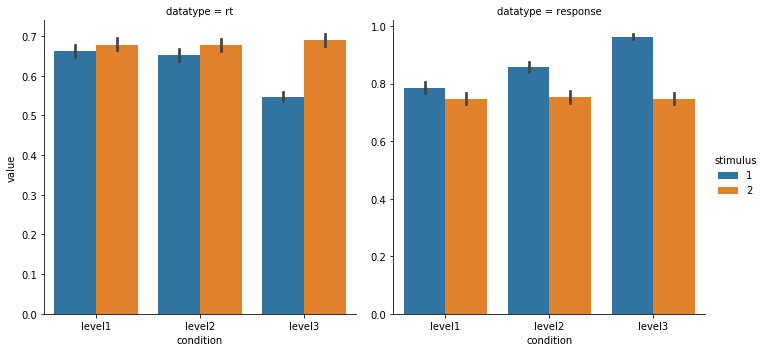

In [5]:
## plot the RT and Accuracy

# wide-to-long format
df_plot = pd.melt(mydata, 
                  id_vars=['subj_idx', 'condition','stimulus'], 
                  value_vars=['rt', 'response'],
                  var_name='datatype')
# df_plot.head()

# way 1: 
# stim_ord = df_plot.stimulus.unique()
# g = sns.FacetGrid(df_plot, col="datatype", 
#                  sharex=False,
#                   sharey=False,
#                  height=4)
# g.map(sns.barplot, "condition", "value",'stimulus', hue_order=np.unique(df_plot["stimulus"]))

# Way 2: 
g = sns.catplot(data=df_plot, x='condition', y='value', hue='stimulus', col='datatype', kind='bar',
               sharex=False, sharey=False)

In [14]:
mydata.columns

Index([u'rt', u'response', u'subj_idx', u'condition', u'stimulus'], dtype='object')

In [26]:
df = mydata.copy()
data = [
            {
                'y': df[(df.condition==c)&(df.stimulus==s)]['rt'],
                'type': 'box', 
                'jitter': 0.3,
                'boxpoints':'all',
                #'fillcolor':
                #'marker': dict(color = df_gls[(df_gls['gls']==group)&(df_gls['sls']==clms)]['cls'].values[0]),
                'boxmean':'sd',
                'name': clms + '_' + c+'_' + str(s)
            } 
                    
                    for clms in ['rt']
                for s in set(df['stimulus'])
            for c in set(df['condition'])
        ]
iplot(Figure(data=Data(data),layout = Layout(showlegend=False)))
#py.image.save_as(Figure(data=Data(data)), filename='a-simple-plot.jpeg')

#### Plot individual data (flip the inaccurate responses)

We can plot the individual data in different ways. 

First, as HDDM's ways, plot all participant's data in one plot, with different color indicate different participant.

Second, we can plot all participants' data by condition, i.e, six plots and each has all participants' data.

Third, we can use interactive plot and we can check each participant's data manually.

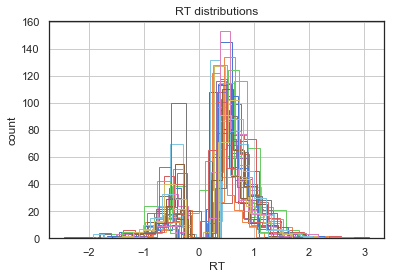

In [29]:
# plot all participant's data in one plot by using HDDM style. 
data = hddm.utils.flip_errors(mydata)
fig = plt.figure()
ax = fig.add_subplot(111, xlabel='RT', ylabel='count', title='RT distributions')
for i, subj_data in data.groupby('subj_idx'):
    subj_data.rt.hist(bins=20, histtype='step', ax=ax)

#plt.savefig('hddm_demo_fig_00.pdf')

In [30]:
def plot_by_con_sti(data):
    f, axes = plt.subplots(3, 2,figsize=(8,8))
    sns.set(style="white", palette="muted", color_codes=True)
    sns.despine(left=True)
    cnt = 0
    for cnt1,c in enumerate(set(data.condition)):
        for cnt2,s in enumerate(set(data.stimulus)):
            rt = data[(data.condition==c)&(data.stimulus==s)].rt
            sns.distplot(rt, color="m", ax=axes[cnt1,cnt2])
            axes[cnt1,cnt2].legend(['condition:'+c+'stimulus:'+str(s)],loc=0)
            cnt = cnt+1

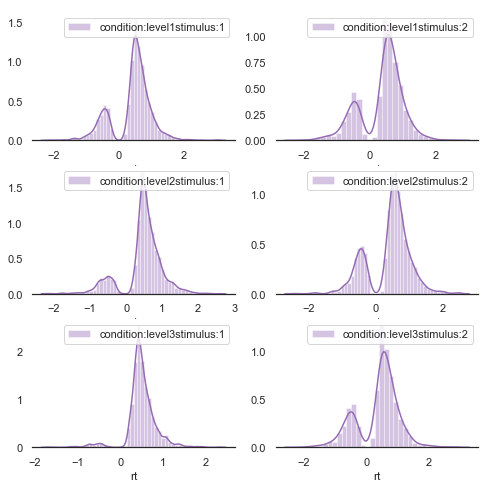

In [31]:
plot_by_con_sti(data)

In [33]:
#plot all participants' data by condition
@interact(sid=set(data.subj_idx))
def iplot_rt(sid):
    data_sub = data[data.subj_idx==sid]
    plot_by_con_sti(data_sub)

interactive(children=(Dropdown(description=u'sid', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29), value=0), Output()), _dom_classes=('widget-interact',))

Here we analyze the data as an experiment and plot it's summary data. More importantly, we will check the correaltion between different condition across subjects.

In [6]:
df_acc = mydata.copy() # cannot use df_acc = mydata, otherwise, mydata will be also changed as df_acc change
df_acc['StimType'] = np.where(df_acc['stimulus'] == 1.0, 'left', 'right')

In [7]:
def plot_sum_cor(df, var = 'rt'):
    '''
    df: simulated dataframe
    var: the variable of which the summary data will be plotted, i.e., rt or response
    '''
    df_sum = df.groupby(['subj_idx', 'condition', 'StimType'])[var].mean().reset_index()

    # long to wide for pair plots
    df_sum_wide = df_sum.pivot_table(index=['subj_idx'], 
                                     columns=['condition','StimType'],
                                          #aggfunc='size', 
                                     values = var,     
                                     fill_value=0) 

    df_sum_wide.columns = df_sum_wide.columns.map('_'.join)
    df_sum_wide = df_sum_wide.reset_index() 

    # plot pairs with regression lines
    sns.pairplot(df_sum_wide.loc[:, df_sum_wide.columns != 'subj_idx'], kind="reg")
    
    print('Here is the correlation matrix of ', var)
    print(df_sum_wide.loc[:, df_sum_wide.columns != 'subj_idx'].corr())

('Here is the correlation matrix of ', 'rt')
              level1_left  level1_right  level2_left  level2_right  \
level1_left      1.000000      0.823877     0.855949      0.847159   
level1_right     0.823877      1.000000     0.803228      0.869241   
level2_left      0.855949      0.803228     1.000000      0.903329   
level2_right     0.847159      0.869241     0.903329      1.000000   
level3_left      0.804430      0.701226     0.894425      0.762943   
level3_right     0.900255      0.853662     0.796581      0.852101   

              level3_left  level3_right  
level1_left      0.804430      0.900255  
level1_right     0.701226      0.853662  
level2_left      0.894425      0.796581  
level2_right     0.762943      0.852101  
level3_left      1.000000      0.645137  
level3_right     0.645137      1.000000  


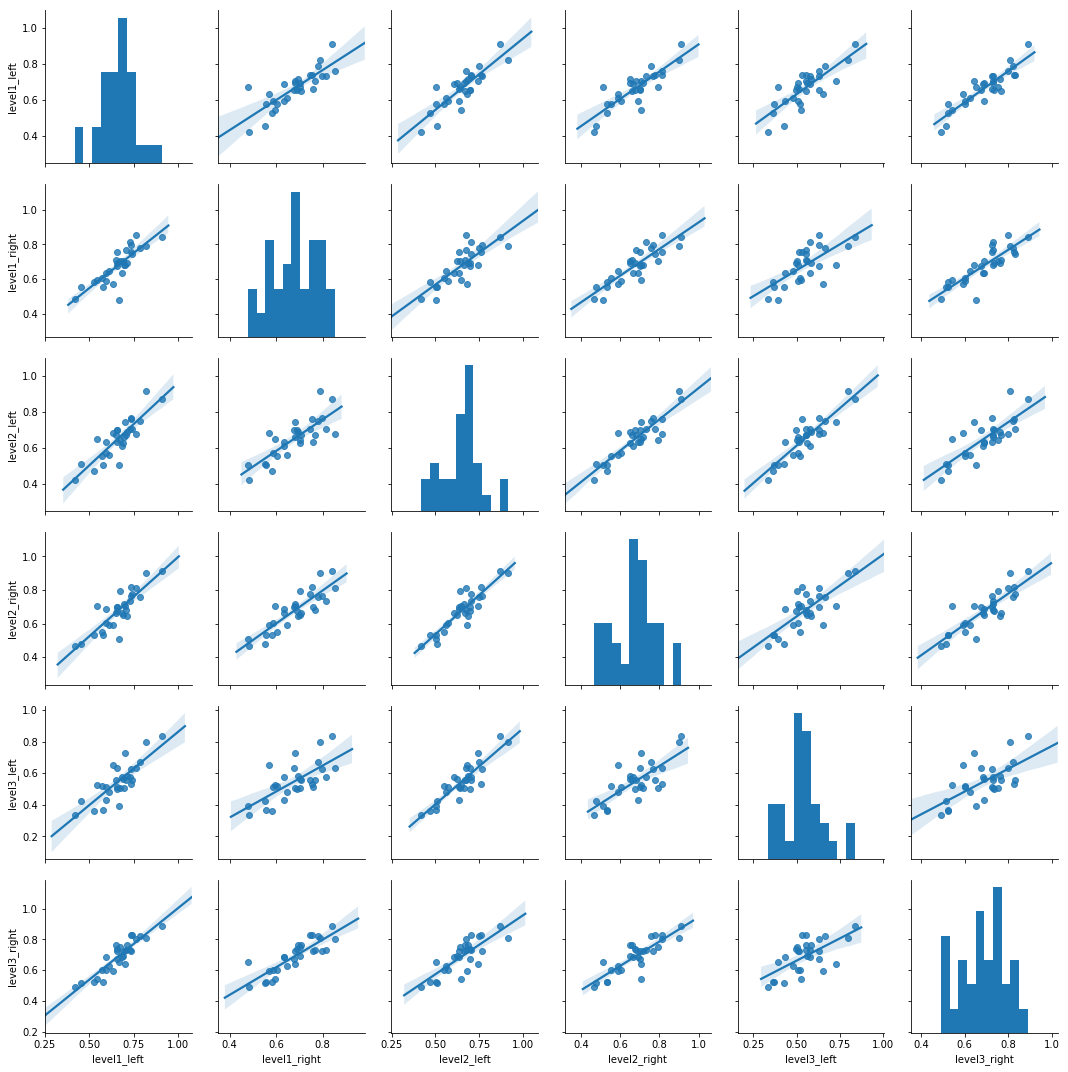

In [8]:
plot_sum_cor(df_acc, 'rt')

('Here is the correlation matrix of ', 'response')
              level1_left  level1_right  level2_left  level2_right  \
level1_left      1.000000      0.773043     0.756150      0.840645   
level1_right     0.773043      1.000000     0.759963      0.861633   
level2_left      0.756150      0.759963     1.000000      0.788028   
level2_right     0.840645      0.861633     0.788028      1.000000   
level3_left      0.724235      0.699335     0.765765      0.673983   
level3_right     0.808591      0.861636     0.831044      0.885592   

              level3_left  level3_right  
level1_left      0.724235      0.808591  
level1_right     0.699335      0.861636  
level2_left      0.765765      0.831044  
level2_right     0.673983      0.885592  
level3_left      1.000000      0.707264  
level3_right     0.707264      1.000000  


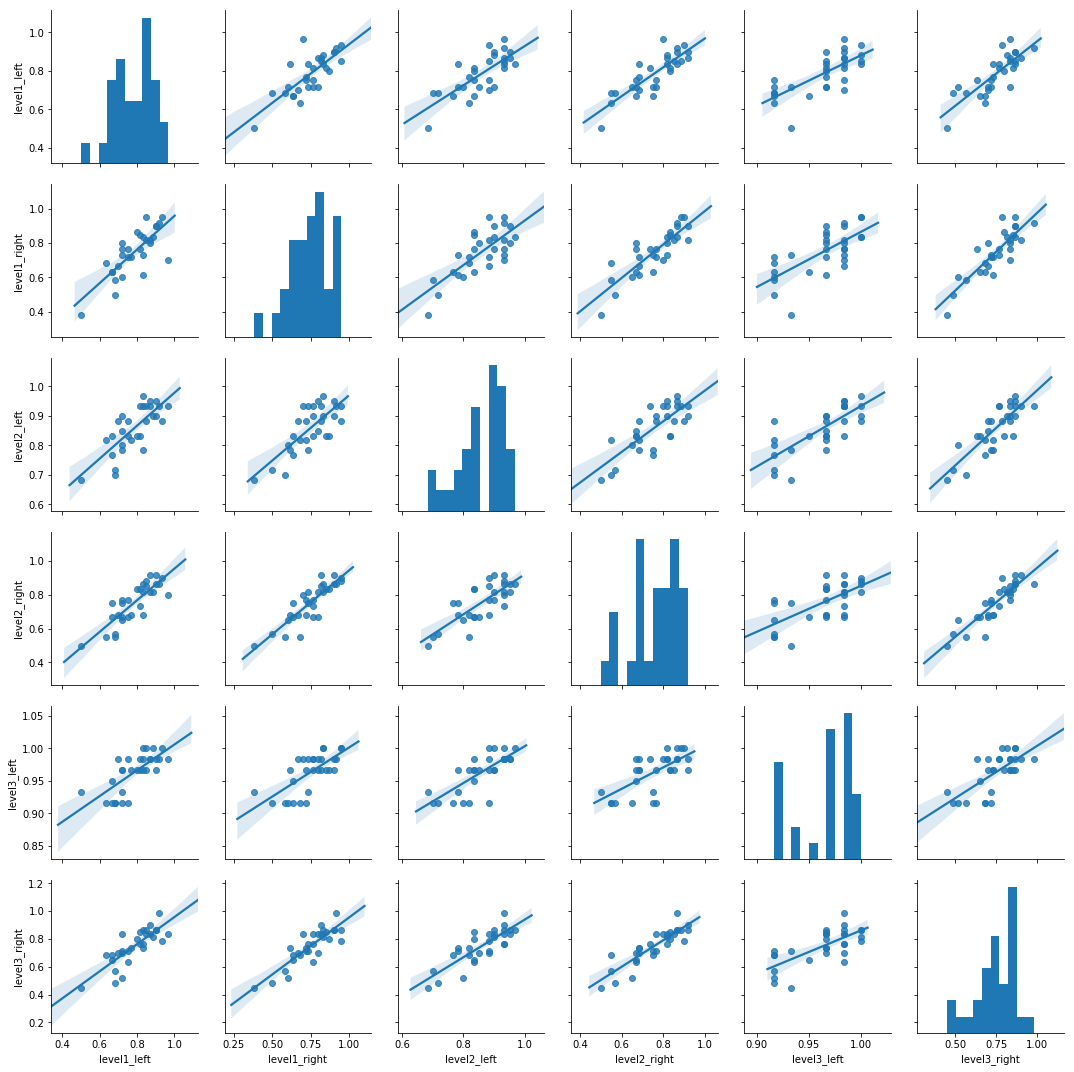

In [9]:
plot_sum_cor(df_acc, 'response')

### Step 3: Prior Check (skipped)

### Step 4: Model building

We will use accuracy-coding for this experiment design.

Use both HDDM and HDDMRegressor module to model the data. For the HDDM we will use the following code:

m1 = hddm.HDDM(df_acc, depends_on={'v': ['condition', 'StimType'], 'z': ['condition', 'StimType']}, 
               include=['v', 'z', 't'],p_outlier=.05)
               
For the regressor model, we will use:

z_reg4 = {'model': "z ~ 1 + C(condition,Treatment('level1')) * C(StimType, Treatment('left'))", 
         'link_func': lambda x:1/(1+np.exp(-x))}

v_reg4 = {'model': "v ~ 1 + C(condition,Treatment('level1')) * C(StimType, Treatment('left'))", 
         'link_func': lambda x:x}

reg_descr4 = [z_reg4, v_reg4]


m4 = hddm.HDDMRegressor(df_acc, reg_descr4, group_only_regressors=False, keep_regressor_trace=True, include='z')

Please Note here the 'group_only_regresors' is set to 'false'

In [10]:
## This chunck of code will run one single chain for each model, 
## usually we first try to run the model in such way and define function for parallel process after.

# m1 = hddm.HDDM(df_acc, depends_on={'v': ['condition', 'StimType'], 'z': ['condition', 'StimType']}, 
#                include=['v', 'z', 't'],p_outlier=.05)


# z_reg = {'model': "z ~ 1 + C(condition,Treatment('level1')) * C(StimType, Treatment('left'))", 
#          'link_func': lambda x:1/(1+np.exp(-x))}

# v_reg = {'model': "v ~ 1 + C(condition,Treatment('level1')) * C(StimType, Treatment('left'))", 
#          'link_func': lambda x:x}

# reg_descr = [z_reg, v_reg]

# m2 = hddm.HDDMRegressor(df_acc, reg_descr, group_only_regressors=False, keep_regressor_trace=True, include='z')

### Step 5: Model estimation in parallel

In [11]:
# define a function for running m1 in parallel


# define a function for running m2 in parallel


### Step 6: Parameter recovery

### Step 7: Convergence Check

### Step 8: Model comparison

### Step 9: Posterior predictive check

### Step 10: Statistical inference and interpretation